In [40]:
import pandas as pd
from sklearn import model_selection
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
import warnings
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('Data/train.csv')
y = train.Transported
test = pd.read_csv('Data/test.csv')
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1100,1165_03,Europa,True,B/44/P,TRAPPIST-1e,29.0,False,0.0,0.0,0.0,0.0,0.0,Nusakab Waring,True
2996,3239_01,Earth,True,G/515/S,TRAPPIST-1e,30.0,False,0.0,0.0,0.0,0.0,0.0,Stanya Bookerson,True
7131,7601_01,Earth,False,G/1232/S,TRAPPIST-1e,17.0,False,214.0,552.0,0.0,241.0,0.0,Amela Starkers,False
3032,3282_03,Europa,False,B/120/S,TRAPPIST-1e,43.0,False,0.0,1440.0,0.0,85.0,150.0,Sheratz Prighty,True
1124,1187_02,Earth,False,G/184/S,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,Hughan Matts,False


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
#how much of the training set is missing?
round(train.isnull().sum()/len(train),2)*100

PassengerId     0.0
HomePlanet      2.0
CryoSleep       2.0
Cabin           2.0
Destination     2.0
Age             2.0
VIP             2.0
RoomService     2.0
FoodCourt       2.0
ShoppingMall    2.0
Spa             2.0
VRDeck          2.0
Name            2.0
Transported     0.0
dtype: float64

### Remarks:
- only variables without missing values are PassengerID and Transported (target variable)
- it looks like ~2% of the dataset is missing

## Preprocessing

In [5]:
# we observe that cabin can be disaggregated
# perhaps we can create a feature that includes total spend (room service, food court, mall, spa, VRdeck)
# additionally passenger name is composed of a first and last name that can be separated
train[['first_name','last_name']] = train.Name.str.split(' ', expand = True).iloc[:,0:2]
train[['deck', 'num', 'side']] = train['Cabin'].str.split('/', expand=True)
train['Total_spend'] = train.RoomService + train.FoodCourt + train.ShoppingMall + train.Spa + train.VRDeck    

<AxesSubplot:xlabel='x', ylabel='y'>

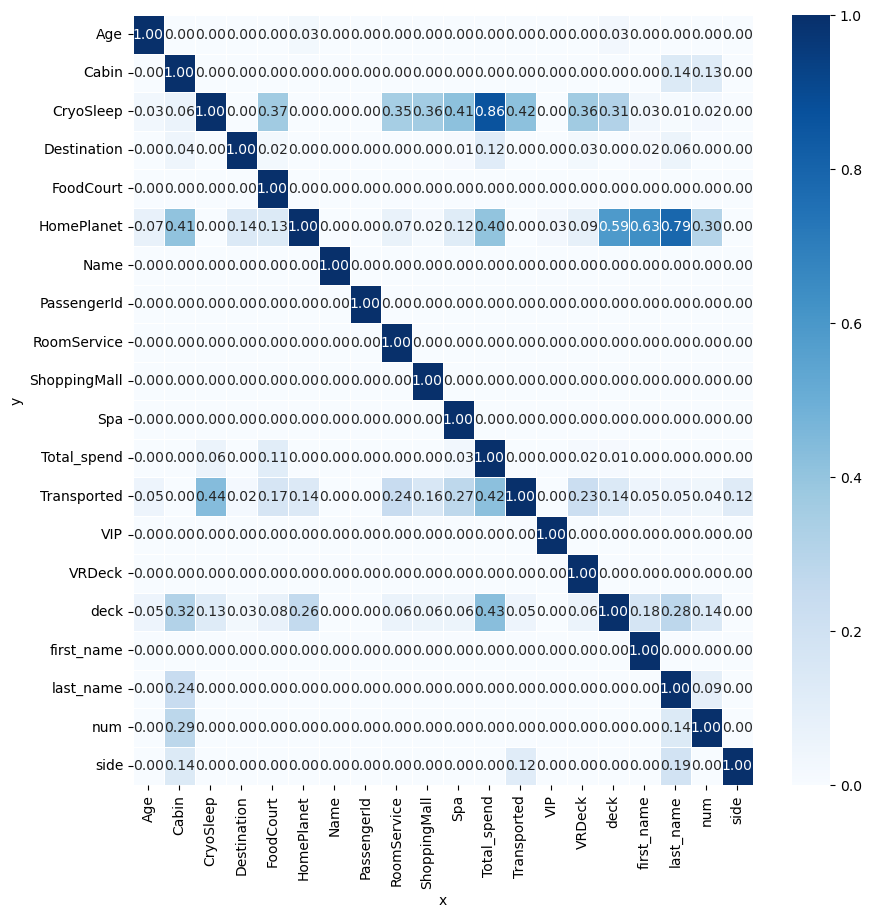

In [6]:
# let's examine some relationships that exist between factors
fig, ax = plt.subplots(figsize = (10,10))
ppscores = pps.matrix(train)
ppscores = ppscores[["x", "y", "ppscore"]].pivot(columns="x", index="y", values="ppscore")
sns.heatmap(
    ppscores, 
    vmin=0, 
    vmax=1, 
    cmap="Blues", 
    linewidths=0.7, 
    annot=True,
    fmt = '.2f'
)

#### Observations
- cyrosleep can be predicted by foodcourt, roomservice, shopping mall, SPA, VRdeck
- furthermore, total spend is a stronger predictor of cyrosleep
- last name has predictive power over home planet

In [7]:
# fill in missing homeplanet values based on lastname
home_planet_dict = train.groupby('last_name')['HomePlanet'].agg(pd.Series.mode).to_dict()
train.HomePlanet = train.HomePlanet.fillna(train.last_name.map(home_planet_dict))

CryoSleep
False    2304.194614
True        0.000000
Name: Total_spend, dtype: float64


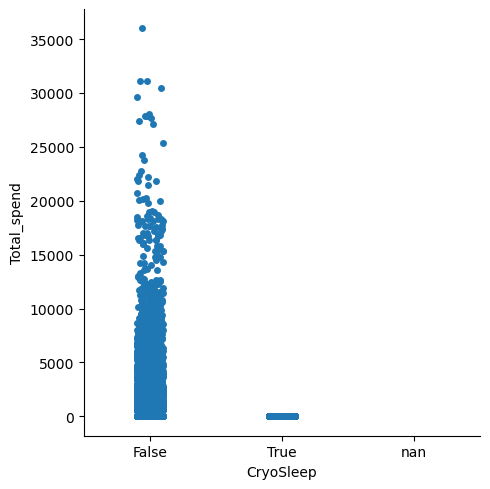

In [8]:
# fill in cyrosleep based on totalspend
sns.catplot(data = train,y = 'Total_spend',x = 'CryoSleep')
print(train.groupby('CryoSleep')['Total_spend'].mean())

In [9]:
# it's logical that if the passenger is in Cryosleep they cannot spend
train.loc[(train.CryoSleep.isna()) & (train.Total_spend == 0),'CryoSleep'] = True

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8686 non-null   object 
 2   CryoSleep     8563 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  first_name    8493 non-null   object 
 15  last_name     8493 non-null   object 
 16  deck          8494 non-null   object 
 17  num           8494 non-null   object 
 18  side          8494 non-null 

In [11]:
# only columns without missing values are passengerId and transported
num_cols = [
    'Age',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'Total_spend'
]
cat_cols = [
    'HomePlanet',
    'CryoSleep',
    'Destination',
    'VIP',
    'first_name',
    'last_name',
    'deck',
    'num',
    'side'
]

In [12]:
# feature engineering function to apply to the whole dataset (train + test)
# Missing categorical features will be filled with 'NONE'
# Missing numerical features will be filled with the median value
def feature_engineer(df):
    df[['first_name','last_name']] = df.Name.str.split(' ', expand = True).iloc[:,0:2]
    df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
    df['Total_spend'] = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck
    # fill in missing homeplanet values based on lastname
    home_planet_dict = df.groupby('last_name')['HomePlanet'].agg(pd.Series.mode).to_dict()
    df.HomePlanet = df.HomePlanet.fillna(df.last_name.map(home_planet_dict))
    # makes sense that if the passenger is in Cryosleep they cannot spend
    df.loc[(df.CryoSleep.isna()) & (df.Total_spend == 0),'CryoSleep'] = True
    # fill numerical values with median
    for i in num_cols:
        df[i] = df[i].fillna(df[i].median())
    # fill categorical variables with NONE
    for i in cat_cols:
        df[i] = df[i].fillna('NONE')
        df[i] = df[i].astype(str)
    return df

In [13]:
# all features
features = [
    f for f in train.columns if f not in (
        'PassengerId','Name','Transported','Cabin'
    )
]

In [14]:
# apply feature engineering to train and test datasets
train_df = feature_engineer(train)
test_df = feature_engineer(test)

# create full dataset with train and test to fit standardscaler and OHE
full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis = 0
    )

In [15]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  object 
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  object 
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  first_name    12970 non-null  object 
 11  last_name     12970 non-null  object 
 12  deck          12970 non-null  object 
 13  num           12970 non-null  object 
 14  side          12970 non-null  object 
 15  Total_spend   12970 non-null  float64
dtypes: float64(7), object(9)
memory usage: 1.7+ MB


In [16]:
# pipeline to scale numerical values and one hot encode categorical values
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline  = ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat',OneHotEncoder(),cat_cols),
])

full_pipeline.fit(full_data)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck',
                                  'Total_spend']),
                                ('cat', OneHotEncoder(),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'first_name', 'last_name', 'deck',
                                  'num', 'side'])])

In [17]:
x_train = full_pipeline.transform(train_df[features])
x_test = full_pipeline.transform(test_df[features])

## Modelling
- our evaluation metric is area under the curve (AUC)
- 1 implies a perfect model, 0 a very bad model, & 0.5 is random

#### Logistic Regression

In [18]:
from sklearn import linear_model
lr_model = linear_model.LogisticRegression()
lr_model.fit(x_train, y)

LogisticRegression()

In [19]:
from sklearn import metrics
logres_preds = lr_model.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,logres_preds),3)}')

AUC = 0.904


In [20]:
# create predictions on test set
test_preds = lr_model.predict(x_test)
sub_logres = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':test_preds
})
sub_logres.to_csv('submissions/logres_submission.csv',
                  index = False)

#### Random Forest

In [25]:
model = ensemble.RandomForestClassifier(n_jobs = -1)
param_grid = {
    'n_estimators':list(range(10,51,10))
}
rf_grid = GridSearchCV(estimator = model, param_grid = param_grid)
rf_grid.fit(x_train,y)
rf_preds = rf_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,rf_preds),3)}')

AUC = 0.998


In [27]:
rf_test_preds = rf_grid.predict(x_test)
sub_rf = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':rf_test_preds
})
sub_rf.to_csv('submissions/rf_submission.csv',
              index = False)

#### K-Nearest Neighbours

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors':list(range(1,50,1))
}
knn_grid = GridSearchCV(estimator = knn, param_grid = param_grid)
knn_grid.fit(x_train, y)
knn_preds = knn_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,knn_preds),3)}')

AUC = 0.809


In [29]:
knn_test_preds = knn_grid.predict(x_test)
sub_knn = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':knn_test_preds
})
sub_knn.to_csv('submissions/knn_submission.csv',
              index = False)

#### Support Vector Machine

In [30]:
from sklearn.svm import SVC

model = SVC()
param_grid = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}
svc_grid = GridSearchCV(estimator = model, param_grid = param_grid)
svc_grid.fit(x_train,y)
svm_preds = svc_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,svm_preds),3)}')

AUC = 0.855


In [33]:
svm_test_preds = svc_grid.predict(x_test)
sub_svm = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':svm_test_preds
})
sub_svm.to_csv('submissions/svm_submission.csv',
              index = False)

#### XGBoost Classifier

In [37]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_jobs = -1,
    booster = 'gbtree'
)
param_grid = {
    "max_depth": list(range(1,10,1)),
    "n_estimators":list(range(10,150,10))
}
xgb_grid = GridSearchCV(estimator = model, param_grid = param_grid)
xgb_grid.fit(x_train,y,eval_metric='auc')
xgb_preds = xgb_grid.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,xgb_preds),3)}')
print(xgb_grid.best_params_)

AUC = 0.824
{'max_depth': 4, 'n_estimators': 40}


In [38]:
xgb_test_preds = xgb_grid.predict(x_test)
sub_xgb = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':xgb_test_preds
})
sub_xgb.to_csv('submissions/xgb_submission.csv',
              index = False)

#### Neural Net: multi-layer perception algo

In [43]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1)
nn.fit(x_train,y)
nn_preds = nn.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,nn_preds),3)}')

AUC = 0.937


In [44]:
nn_test_preds = nn.predict(x_test)
sub_nn = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':nn_test_preds
})
sub_nn.to_csv('submissions/nn_submission.csv',
              index = False)

#### Ensemble Learning
- the random forest model appears to be overfitting the data
- let's create an ensemble with all the models except for random forest
- use softvoting so the model with high conviction will prevail

In [49]:
model = SVC(probability = True)
param_grid = {
    "kernel": ["linear","rbf"],
    "C":[0.1,1,10]
}
svc_grid = GridSearchCV(estimator = model, param_grid = param_grid)
from sklearn.ensemble import VotingClassifier 
est_ensemble = VotingClassifier(estimators=[('nn', nn),
                                            ('lr', lr_model), 
                                            ('xgb', xgb_grid),
                                            ('knn', knn_grid),
                                            ('svc', svc_grid)],
                                voting='soft',
                                weights=[1,1,1,1,1])
est_ensemble

VotingClassifier(estimators=[('nn',
                              MLPClassifier(alpha=1e-05,
                                            hidden_layer_sizes=(5, 2),
                                            random_state=1, solver='lbfgs')),
                             ('lr', LogisticRegression()),
                             ('xgb',
                              GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   enable_categorical=False,
                                                                   gamma=None,
                                                                   gpu_id=None,
                                                                   importance_t...
                                                                        50, 60,
                                                                        70, 80,
                                                                        90, 100,
                                                                        110,
                                                                        120,
                                                                        130,
                                                                        140]})),
                             ('knn',
                              GridSearchCV(estimator=KNeighborsClassifier(),
                                           param_grid={'n_neighbors': [1, 2, 3,
                                                                       4, 5, 6,
                                                                       7, 8, 9,
                                                                       10, 11,
                                                                       12, 13,
                                                                       14, 15,
                                                                       16, 17,
                                                                       18, 19,
                                                                       20, 21,
                                                                       22, 23,
                                                                       24, 25,
                                                                       26, 27,
                                                                       28, 29,
                                                                       30, ...]})),
                             ('svc',
                              GridSearchCV(estimator=SVC(probability=True),
                                           param_grid={'C': [0.1, 1, 10],
                                                       'kernel': ['linear',
                                                                  'rbf']}))],
                 voting='soft', weights=[1, 1, 1, 1, 1])

In [ ]:
est_ensemble.fit(x_train,y)
ens_pred = est_ensemble.predict(x_train)

In [51]:
print(f'AUC = {round(metrics.roc_auc_score(y,ens_pred),3)}')

AUC = 0.896


In [52]:
ens_test_preds = est_ensemble.predict(x_test)
sub_ens = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Transported':ens_test_preds
})
sub_ens.to_csv('submissions/ens_submission.csv',
              index = False)